In [1]:
import lstm_clv
from lstm_clv.api_utils import plot_training_history

DATAPATH = "data-fintech"

## Scenario 1: aggregate all products & compare against benchmark

In [2]:
EXPERIMENT = "fintech_aggregated"

config = lstm_clv.make_config(
    experiment_name=EXPERIMENT,
    raw_data_path=DATAPATH,
    aggregate_events=True,
    min_nr_actions=5,
    epochs=50,
    early_stop_after_epochs=5,
    verbose=0
)
lstm_clv.create_experiment(config)

In [3]:
prep = lstm_clv.prepare_data(EXPERIMENT)
user_ids = prep.user_ids  # keep list of users to re-use later on

2021-11-26 22:38:48,289 preparation [INFO] Keeping only users with > 5 actions
2021-11-26 22:38:48,469 preparation [INFO] All data: UserEvents with 19919 users, 70 weeks, 414043 nonzero events, avg. of 20.79 per user
2021-11-26 22:38:48,477 preparation [INFO] Train: UserEvents with 19919 users, 60 weeks, 336488 nonzero events, avg. of 16.89 per user


In [4]:
benchmark = lstm_clv.evaluate_benchmark(EXPERIMENT)
benchmark.performance

2021-11-26 22:38:55,961 benchmark [INFO] Predicting values for weeks 60--70 (10 weeks) for 19919 users.
/Users/gleb/.local/share/virtualenvs/master-thesis-XJPTMYr8/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model performance: 
{
    "r2": 0.3116,
    "mse": 1647881.3264,
    "mae": 199.4852,
    "hit_ratio_top_50": 0.6939,
    "hit_ratio_top_25": 0.5405,
    "hit_ratio_top_10": 0.4252,
    "avg_clv_true": 36.42104,
    "avg_clv_pred": 224.48159,
    "total_true": 725470.77,
    "total_pred": 4471448.879
}

In [5]:
# find best hyperparameters for the LSTM-CLV

parameter_search = lstm_clv.ParameterGridSearch(
    experiment=EXPERIMENT,
    lstm_window=[3, 6, 12, 24],
    lstm_units=[25, 50, 100, 150],
    learning_rate=[0.001, 0.01, 0.05, 0.1],
    batch_size=[100, 500, 1000]
)
parameter_search.optimize(max_combinations=30, target="val_loss")

2021-11-26 22:39:09,600 grid_search [INFO] Computing 30 out of 192 grid combinations using 12 available CPUs.
2021-11-26 23:34:32,510 grid_search [INFO] Config updated with best parameters: {'lstm_window': 24, 'lstm_units': 25, 'learning_rate': 0.001, 'batch_size': 1000, 'loss': 0.2849}


,lstm_window,lstm_units,learning_rate,batch_size,loss
0,3,25,0.100,100,0.4682
1,3,100,0.100,500,0.6517
2,3,50,0.001,100,0.4702
3,6,100,0.001,100,0.4195
4,12,100,0.050,1000,0.3311
5,6,25,0.010,1000,0.4197
6,3,150,0.100,1000,0.6194
7,12,100,0.100,500,0.4587
8,12,25,0.100,100,0.4393
9,3,100,0.050,100,0.6511


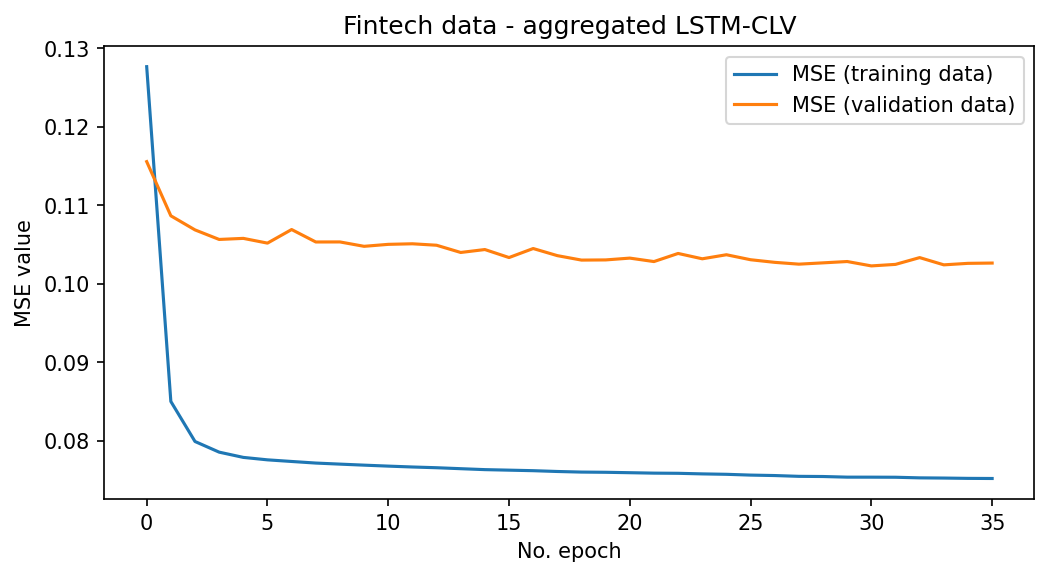

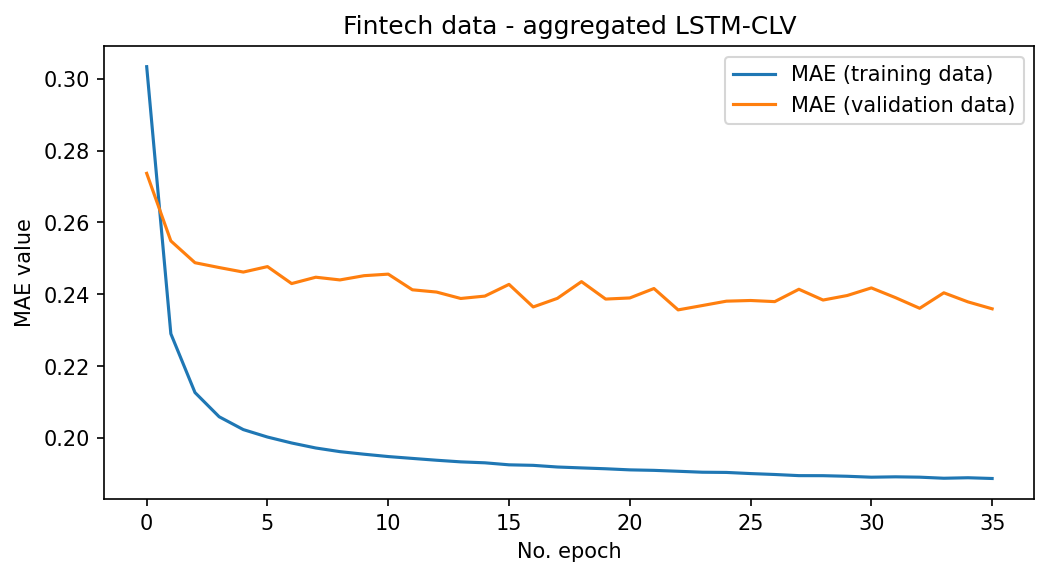

In [6]:
# re-train the model for the best combination of parameters

history = lstm_clv.train_lstm(EXPERIMENT)
plot_training_history(history, title="Fintech data - aggregated LSTM-CLV")

In [7]:
lstm_clv.evaluate_lstm(EXPERIMENT)

2021-11-27 09:03:16,024 lstm-model [INFO] Predicting values for weeks 60--70


Model performance: 
{
    "r2": 0.0606,
    "mse": 49063.095,
    "mae": 33.3043,
    "hit_ratio_top_50": 0.7712,
    "hit_ratio_top_25": 0.6149,
    "hit_ratio_top_10": 0.4408,
    "avg_clv_true": 36.42108,
    "avg_clv_pred": 5.9047,
    "total_true": 725471.4933,
    "total_pred": 117615.6348
}
Distribution of true values:
     min      mean         max        std
ALL  0.0  3.642108  8028.63579  19.515579
Distribution of predicted values:
          min     mean       max       std
ALL  0.059905  0.59047  6.888834  0.124214

## Scenario 2: Product-level CLV

In [8]:
EXPERIMENT_2 = "fintech_product_level"

config = lstm_clv.make_config(
    experiment_name=EXPERIMENT_2,
    raw_data_path=DATAPATH,
    aggregate_events=False,
    keep_user_ids=user_ids,  # taking same users as for aggregated scenario
    epochs=50,
    early_stop_after_epochs=5,
    verbose=0,
)
lstm_clv.create_experiment(config)

In [9]:
lstm_clv.prepare_data(EXPERIMENT_2)

2021-11-27 09:04:08,370 preparation [INFO] Keeping only users from the provided list
2021-11-27 09:04:15,230 preparation [INFO] All data: UserEvents with 19919 users, 70 weeks, 1247265 nonzero events, avg. of 62.62 per user
2021-11-27 09:04:15,292 preparation [INFO] Train: UserEvents with 19919 users, 60 weeks, 1021138 nonzero events, avg. of 51.26 per user


In [10]:
parameter_search = lstm_clv.ParameterGridSearch(
    experiment=EXPERIMENT_2,
    lstm_window=[3, 6, 12, 24],
    lstm_units=[25, 50, 100, 150],
    learning_rate=[0.001, 0.01, 0.05, 0.1],
    batch_size=[100, 500, 1000]
)
parameter_search.optimize(max_combinations=30, target="val_loss")

2021-11-27 09:04:34,028 grid_search [INFO] Computing 30 out of 192 grid combinations using 12 available CPUs.
2021-11-27 09:52:34,179 grid_search [INFO] Config updated with best parameters: {'lstm_window': 24, 'lstm_units': 25, 'learning_rate': 0.001, 'batch_size': 100, 'loss': 0.2055}


,lstm_window,lstm_units,learning_rate,batch_size,loss
0,12,25,0.100,1000,0.2924
1,24,25,0.100,500,0.2491
2,24,25,0.010,500,0.2066
3,24,50,0.050,1000,0.2252
4,6,25,0.100,500,0.3583
5,3,50,0.100,1000,0.3831
6,24,25,0.050,1000,0.2111
7,3,100,0.001,100,0.3236
8,12,50,0.100,100,0.5575
9,3,50,0.050,500,0.3401


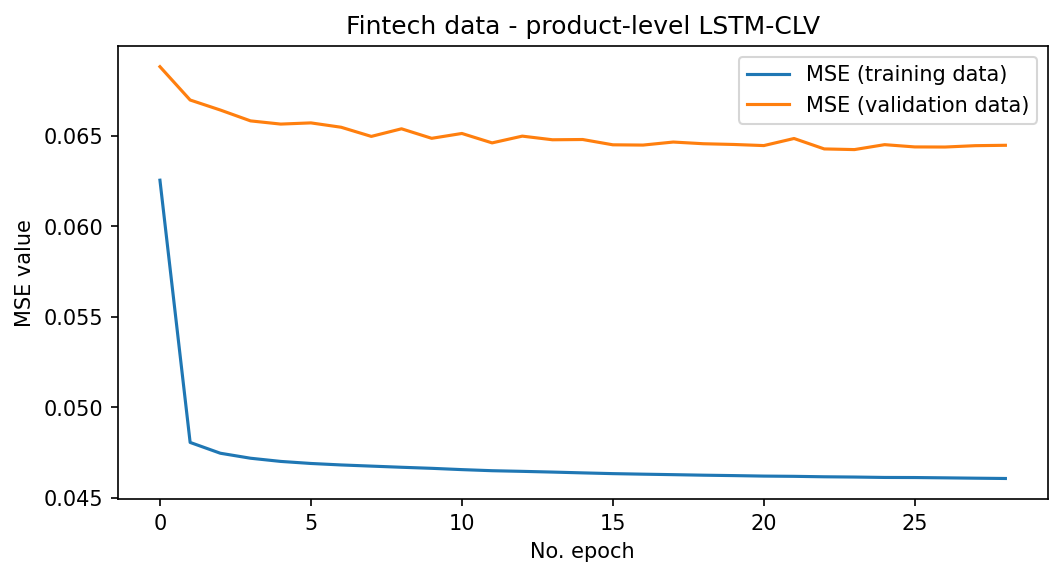

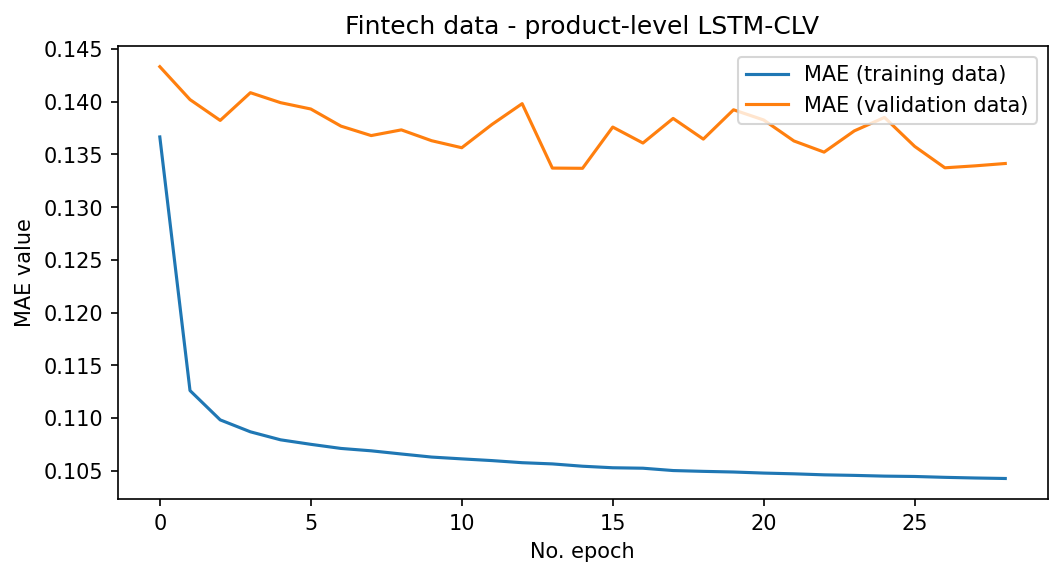

In [11]:
history = lstm_clv.train_lstm(EXPERIMENT_2)
plot_training_history(history, title="Fintech data - product-level LSTM-CLV")

In [12]:
lstm_clv.evaluate_lstm(EXPERIMENT_2)

2021-11-27 10:14:37,161 lstm-model [INFO] Predicting values for weeks 60--70


Model performance: 
{
    "r2": 0.0179,
    "mse": 50171.8493,
    "mae": 36.1426,
    "hit_ratio_top_50": 0.7185,
    "hit_ratio_top_25": 0.4835,
    "hit_ratio_top_10": 0.2716,
    "avg_clv_true": 36.42108,
    "avg_clv_pred": 0.3664,
    "total_true": 725471.4946,
    "total_pred": 7298.2405
}
Distribution of true values:
                    min        mean         max          std
application_opened  0.0   12.158145    1260.000    10.850691
product A           0.0   45.572338  358518.268  1059.523613
product B           0.0   28.710758   11341.540    44.321111
product C           0.0  112.884732  802863.579  1555.364080
m_b_iban_shared     0.0    0.027029      26.000     0.036838
product D           0.0   83.873522  406250.250  1002.967807
product E           0.0   93.169450   21965.411   229.219288
Distribution of predicted values:
                         min      mean         max       std
application_opened  0.006463  2.498701   83.685081  1.488137
product A           0.000204 